In [1]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

tf.__version__

/home/felipe/anaconda3/envs/deep-learning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.4.1'

In [2]:
start_token = '\t'
end_token = '\n'
batch_size = 100
epochs = 100
latent_dim = 256
num_samples = 10000
data_path = 'data/fra.txt'

In [3]:
input_seqs = []
target_seqs = []
input_tokens = set()
target_tokens = set()

with open(data_path, 'r', encoding='utf-8') as file:
    lines = file.read().split('\n')
    
for line in lines[: min(num_samples, len(lines)-1)]:
    input_seq, target_seq = line.split('\t')
    
    target_seq = start_token + target_seq + end_token
    
    input_seqs.append(input_seq)
    target_seqs.append(target_seq)
    
    for token in input_seq:
        if token not in input_tokens:
            input_tokens.add(token)
            
    for token in target_seq:
        if token not in target_tokens:
            target_tokens.add(token)
            
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

max_encoder_seq_length = max([len(seq) for seq in input_seqs])
max_decoder_seq_length = max([len(seq) for seq in target_seqs])

input_token_index = dict([(token, index) for index, token in enumerate(input_tokens)])
target_token_index = dict([(token, index) for index, token in enumerate(target_tokens)])

rev_input_token_index = dict([(index, token) for index, token in enumerate(input_tokens)])
rev_target_token_index = dict([(index, token) for index, token in enumerate(target_tokens)])

encoder_input_data = np.zeros((len(input_seqs), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_seqs), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_seqs), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_seq, target_seq) in enumerate(zip(input_seqs, target_seqs)):
    for j, token in enumerate(input_seq):
        encoder_input_data[i, j, input_token_index[token]] = 1.
    for j, token in enumerate(target_seq):
        decoder_input_data[i, j, target_token_index[token]] = 1.
        if j > 0:
            decoder_target_data[i, j-1, target_token_index[token]] = 1.

In [4]:
encoder_inputs = tf.placeholder(shape=(None,None,num_encoder_tokens), dtype=tf.float32, name='encoder_inputs')
decoder_inputs = tf.placeholder(shape=(None,None,num_decoder_tokens), dtype=tf.float32, name='decoder_inputs')
decoder_targets = tf.placeholder(shape=(None,None,num_decoder_tokens), dtype=tf.float32, name='decoder_targets')

In [5]:
encoder_cell = tf.contrib.rnn.LSTMCell(latent_dim)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs,
    dtype=tf.float32,
)

del encoder_outputs

In [6]:
decoder_cell = tf.contrib.rnn.LSTMCell(latent_dim)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs,
    dtype=tf.float32,
    initial_state=encoder_final_state,
    scope='plain_decoder'
)

In [7]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, num_decoder_tokens)
decoder_predicition = tf.argmax(decoder_logits, 2)

In [8]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=decoder_targets,
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)


In [9]:
decoder_targets

<tf.Tensor 'decoder_targets:0' shape=(?, ?, 94) dtype=float32>

In [10]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 94) dtype=float32>

In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
def create_batches(input_data, batch_size=100):
    num_batches = int(np.ceil(input_data.shape[0] / batch_size))
    batches = []
    for batch in np.arange(num_batches):
        start = batch * batch_size
        end = (batch+1) * batch_size
        batches.append(input_data[start:end,:,:])
        
    return batches, num_batches   

In [13]:
encoder_input_batches, _ = create_batches(encoder_input_data, batch_size)
decoder_input_batches, _ = create_batches(decoder_input_data, batch_size)
decoder_target_batches, num_batches = create_batches(decoder_target_data, batch_size)

In [14]:
def next_feed(batch_index):
    return {
        encoder_inputs: encoder_input_batches[batch_index],
        decoder_inputs: decoder_input_batches[batch_index],
        decoder_targets: decoder_target_batches[batch_index]
    }

In [15]:
num_batches

100

In [16]:
loss_track = []
checkpoint = 10

try:
    for epoch in range(epochs):
        total_loss = 0
        for batch in range(num_batches):
            fd = next_feed(batch)
            _, l = sess.run([train_op, loss], fd)
            total_loss += l

        total_loss /= num_batches    
        loss_track.append(total_loss)
        print('epoch {}'.format(epoch + 1))
        print('\t minibatch loss: {}'.format(total_loss))
        
except KeyboardInterrupt:
    print('training interrupted')

epoch 1
	 minibatch loss: 1.491408224105835
epoch 2
	 minibatch loss: 1.4785189986228944
epoch 3
	 minibatch loss: 1.4645978176593781
epoch 4
	 minibatch loss: 1.4475791996717453
epoch 5
	 minibatch loss: 1.422972947359085
epoch 6
	 minibatch loss: 1.3895596253871918
epoch 7
	 minibatch loss: 1.356590126156807
epoch 8
	 minibatch loss: 1.3295823299884797
epoch 9
	 minibatch loss: 1.309317536354065
epoch 10
	 minibatch loss: 1.2950420951843262
epoch 11
	 minibatch loss: 1.2840724736452103
epoch 12
	 minibatch loss: 1.2710555845499039
epoch 13
	 minibatch loss: 1.2518272715806962
epoch 14
	 minibatch loss: 1.2267791444063187
epoch 15
	 minibatch loss: 1.2062312895059586
epoch 16
	 minibatch loss: 1.1920768052339554
epoch 17
	 minibatch loss: 1.1806173831224442
epoch 18
	 minibatch loss: 1.170484355688095
epoch 19
	 minibatch loss: 1.1617117249965667
epoch 20
	 minibatch loss: 1.15437109708786
epoch 21
	 minibatch loss: 1.1482348477840423
epoch 22
	 minibatch loss: 1.14305905520916
epoch 

In [18]:
saver = tf.train.Saver()
save_path = saver.save(sess, "model/seq2seq.ckpt")

loss 1.0744 after 10000 examples (batch_size=100)


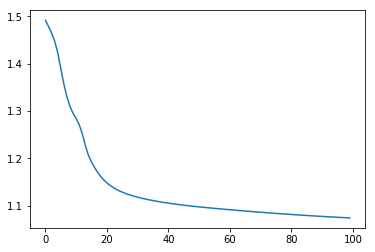

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))